Lecture 5
===========================================================================

Multivariable unconstrained optimisation
------------

In [1]:
from __future__ import division
from __future__ import print_function

In [2]:
import sympy
sympy.init_printing(use_latex='mathjax')

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


Techniques which require only function values
==========

Downhill Simplex or Sequential Simplex method
------------

A simplex is simply a polytope (multidimensional version of polygon) with $n+1$ vertices (points) in $n$-dimensional space

In two dimensions, this is a triangle, in three, it is a tetrahedron

The Nelder-Mead version of the simplex algorithm is very commonly implemented in numerical libraries and has the advantage of only needing function values.

In [3]:
x1, x2 = sympy.symbols('x1 x2')

In [4]:
f = (x1 - 3)**2 + (x2 - 3)**2 + (x1 - 3)*(x2 - 3)
f

        2                               2
(x₁ - 3)  + (x₁ - 3)⋅(x₂ - 3) + (x₂ - 3) 

In [5]:
def gradient(f, variables):
    return [f.diff(variable) for variable in variables]

In [6]:
df = gradient(f, [x1, x2])
df

[2⋅x₁ + x₂ - 9, x₁ + 2⋅x₂ - 9]

In [9]:
minxy = sympy.solve([df[0], df[1]], [x1, x2])

In [10]:
minxy

{x₁: 3, x₂: 3}

In [15]:
def plotfunc(f, xlim, ylim, plotquiver=None, reddot=None):
    evalf = sympy.lambdify((x1, x2), f, modules=['numpy'])
    xl = np.linspace(xlim[0], xlim[1], 20)
    yl = np.linspace(xlim[0], xlim[1], 20)
    xx, yy = np.meshgrid(xl, yl)
    zz = evalf(xx, yy)
    plt.contourf(xx, yy, zz, cmap='binary_r')
    if plotquiver:
        df = gradient(f, [x1, x2])
        evalgrad = [sympy.lambdify((x1, x2), dfi, modules=['numpy']) for dfi in df]
        vx1, vx2 = [-evd(xx, yy) for evd in evalgrad]
        plt.quiver(xx, yy, vx1, vx2, headwidth=4, headlength=6, color='r')
    if reddot:
        plt.scatter(reddot[x1], reddot[x2], s=100, color='red')

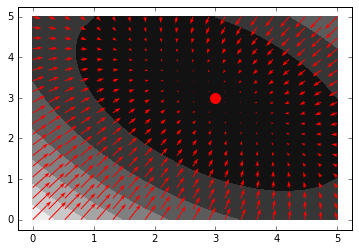

In [16]:
plotfunc(f, (0., 5.), (0., 5.), plotquiver=True, reddot=minxy)

In [17]:
import numpy

In [21]:
# simple simplex method implementation - only reflection
def simplex_method(f, alpha, N, simplex0):
    evalf = sympy.lambdify((x1, x2), f)
    simplex = simplex0
    simplexes = [simplex] # initial simplex
    for i in range(N):
        # Evaluate all points in simplex
        fs = [evalf(*point) for point in simplex]
        # sort points in simplex according to function value (so the last point is the worst)
        sortedfs, sortedsimplex = zip(*sorted(zip(fs, simplex), key=lambda x: x[0]))
        # calculate center of all but last point
        center = numpy.mean(sortedsimplex[:-1], axis=0)
        reflectedpoint = center + alpha*(center - sortedsimplex[-1])
        simplex = list(sortedsimplex[:-1]) + [reflectedpoint]
        simplexes.append(simplex)
    return simplexes

In [22]:
initialsimplex = [numpy.array(v) for v in [(0, 0), (0.2, 0.9), (0.9, 0.2)]]

In [23]:
simplex_method(f, 1, 4, initialsimplex)

[[array([0, 0]), array([ 0.2,  0.9]), array([ 0.9,  0.2])],
 [array([ 0.2,  0.9]), array([ 0.9,  0.2]), array([ 1.1,  1.1])],
 [array([ 1.1,  1.1]), array([ 0.2,  0.9]), array([ 0.4,  1.8])],
 [array([ 1.1,  1.1]), array([ 0.4,  1.8]), array([ 1.3,  2. ])],
 [array([ 1.3,  2. ]), array([ 1.1,  1.1]), array([ 2. ,  1.3])]]

In [25]:
import matplotlib.patches as patches
from ipywidgets import interact

In [31]:
def show_simplex(alpha=0.8, N=20):
    simplex = simplex_method(f, alpha, N, initialsimplex)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plotfunc(f, (0, 5), (0, 5), reddot=minxy)
    for i in range(np.shape(simplex)[0]):
        poly = patches.Polygon(simplex[i], edgecolor='r', facecolor='none')
        ax.add_patch(poly)
    plt.show()

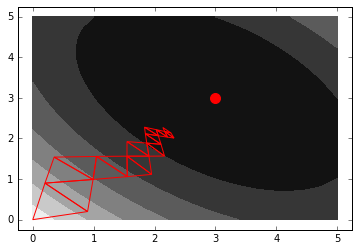

<function __main__.show_simplex>

In [32]:
interact(show_simplex, N=(1, 50), alpha=(0.0, 1.0, 0.01))

Conjugate direction search
------------
Vectors $\mathbf{s}^i$ and $\mathbf{s}^j$ are said to conjugate with respect to matrix Q if 

${\mathbf{s}^i}^TQ\mathbf{s}^j=0$

The set of directions which satisfy these equations is known as the nullspace or kernel of the matrix. For optimisation the matrix Q is the Hessian matrix.

Example 6.1:

In [34]:
x1, x2 = sympy.symbols('x1 x2')
f = 2*x1**2 + x2**2 - 3
H = sympy.hessian(f, [x1,x2])
f, H

⎛    2     2            ⎞
⎜2⋅x₁  + x₂  - 3, ⎡4  0⎤⎟
⎜                 ⎢    ⎥⎟
⎝                 ⎣0  2⎦⎠

In [36]:
minxy = sympy.solve(gradient(f, [x1, x2]), [x1, x2])

Start the search at the point [1,1] with an initial direction ${\mathbf{s}^i}^T$ = [-4,-2]. To find the conjugate direction we determine the nullspace of ${\mathbf{s}^i}^TQ$:

In [37]:
s1 = sympy.Matrix([-4, -2]).T
A = s1*H
s1conj = A.nullspace()[0]
s1conj

⎡-1/4⎤
⎢    ⎥
⎣ 1  ⎦

To be consistent with the textbook we multiply this vector by -4, an operation which does not change its direction. To be sure we can check the original requirement:

In [39]:
s1conj = s1conj*(-4)
s1*H*s1conj

[0]

The original direction and the conjugate directions are indicated on the figure.

In [40]:
def plot_vector(p1, p2, color='b'):
    ax = plt.gca()
    ax.arrow(float(p1[0]), float(p1[1]), float(p2[0]), float(p2[1]), 
             head_width=0.5, head_length=0.5, 
             fc=color, ec=color)


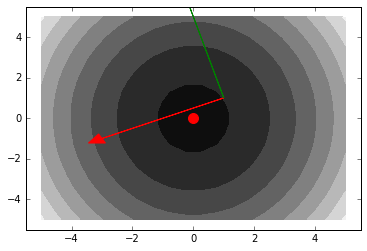

In [41]:
plotfunc(f, (-5, 5), (-5, 5), reddot=minxy)
plot_vector((1, 1), (-4, -2), 'r')
plot_vector((1, 1), s1conj, 'g')
plt.show()

To find the optimal value we must take a step in the initial direction:
   ${\mathbf{x}_{new} = \mathbf{x}_{old} + \alpha\mathbf{s}}$

Or for the individual directions:

$${{x}_{1,new} = {x}_{1,old} + \alpha{s}_{1}}$$

$${{x}_{2,new} = {x}_{2,old} + \alpha{s}_{2}}$$

To determine the optimal step size we conduct a line search in the initial direction, for convenience we keep the step size fixed as opposed to before when we gradually increased it. 

In [43]:
def vec_wrap(func):
    lambdified_func = sympy.lambdify((x1, x2), func)
    def vector_evaluator(x):
        return numpy.array(lambdified_func(*x))
    return vector_evaluator

In [46]:
alpha = 0.01
s0 = sympy.Matrix([1.0, 1.0])
spoints = [s0]
newvals = s0 + alpha * s1.T
spoints.append(newvals)
k = 1

while f.subs([(x1,spoints[k][0]),(x2,spoints[k][1])]) <  f.subs([(x1,spoints[k-1][0]),(x2,spoints[k-1][1])]):
    k = k + 1
    newvals = s0 + alpha * k * s1.T
    spoints.append(newvals)

print (alpha * k )   

0.29


The search indicates that we will be at the minimum value of f along the direction ${\mathbf{s}^i}^T$ = [-4,-2] if we multiply this vector by 0.29, this makes the new starting point:

In [47]:
s2 = s0 + alpha * k * s1.T
s2

⎡-0.16⎤
⎢     ⎥
⎣0.42 ⎦

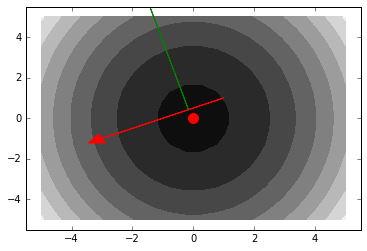

In [48]:
fig, ax = plt.subplots()
plotfunc(f, (-5, 5), (-5, 5), reddot=minxy)
plot_vector((1, 1), (-4, -2), 'r')
plot_vector(s2, s1conj, 'g')
plt.show()

Performing another line search in the conjugate direction from this new starting point:

In [51]:
alpha = 0.01
spoints = [s2]
newvals = s2 + alpha * s1conj
spoints.append(newvals)
k = 1
evalf = vec_wrap(f)
while evalf(spoints[k]) <  evalf(spoints[k-1]):
    k = k + 1
    newvals = s2 + alpha * k * s1conj
    spoints.append(newvals)

print (alpha * k   )

0.01


Thus if we multiply the conjugate vector by 0.12 and add it to the starting point we obtain the optimal value:

In [52]:
s2 + alpha * k * s1conj

⎡-0.2⎤
⎢    ⎥
⎣0.58⎦

This is very close to the true optimum of (0,0), to obtain a better value smaller steps of ${\alpha}$ could be used. The reason we achieve the optimal solution in only two steps is because the function is quadratic.

Techniques which require function derivatives
==========

Conjugate gradient search
------------
This approach combines the use of conjugate directions with the use of the gradient 


Newton's method
------------
This approach combines the use of conjugate directions with the use of the gradient 


Built-in functions
---------------

SciPy offers implementations of some of the methods discussed in the book in the standard entry point `scipy.optimize.minimise`:

In [53]:
import scipy.optimize

Let's unleash a couple of methods on the Rosenbrock function (the function from Example 6.2)

In [54]:
import numpy

In [57]:
x1, x2 = sympy.symbols('x1 x2')
rosenbrock = 100*(x2 - x1**2)**2 + (1 - x1)**2
rosenjac = [sympy.diff(rosenbrock, v) for v in [x1, x2]]

In [58]:
f = vec_wrap(rosenbrock)
df = vec_wrap(rosenjac)

In [60]:
for algorithm in ['Nelder-Mead', 'Powell', 'BFGS', 'Newton-CG']:
    print(algorithm)
    print(scipy.optimize.minimize(f, [-1.2, 1], method=algorithm, jac=df))

Nelder-Mead
 final_simplex: (array([[ 1.00002202,  1.00004222],
       [ 0.99999529,  0.99998729],
       [ 0.99997589,  0.9999541 ]]), array([  8.17766120e-10,   1.10754897e-09,   1.12292970e-09]))
           fun: 8.177661197416674e-10
       message: 'Optimization terminated successfully.'
          nfev: 159
           nit: 85
        status: 0
       success: True
             x: array([ 1.00002202,  1.00004222])
Powell
   direc: array([[  1.21577431e-02,   2.56492590e-02],
       [  1.42194769e-06,   2.71652508e-06]])
     fun: array(1.787366526385165e-26)
 message: 'Optimization terminated successfully.'
    nfev: 665
     nit: 23
  status: 0
 success: True
       x: array([ 1.,  1.])
BFGS
      fun: 1.7058125093715689e-15
 hess_inv: array([[ 0.49985879,  0.99978163],
       [ 0.99978163,  2.00458044]])
      jac: array([  1.65405202e-06,  -8.25346035e-07])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 35
     njev: 51
   status: 0
  success: True
  

/Users/alchemyst/anaconda3/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/Users/alchemyst/anaconda3/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
